In [1]:
!pip install plot_model

In [ ]:
#!pip install imbalanced-learn

In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

import os
import keras
#import tensorflow.python.keras.utils.vis_utils
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder, label_binarize

import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from xgboost import XGBClassifier # XGBClassifier

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the directory containing the .pkl file
os.chdir('/content/drive/MyDrive/Alzheimer_s Dataset/')

# Load the volumes_array.pkl file
with open('volumes_array.pkl', 'rb') as f:
    volumes_array = pickle.load(f)

# Load the labels_array.pkl file if available
with open('labels_array1.pkl', 'rb') as f:
    labels_array = pickle.load(f)

# Display the length of volumes_array
print("Length of volumes_array:", len(volumes_array))

# Display the length of volumes_array
print("Length of volumes_array:", len(labels_array))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Length of volumes_array: 1223
Length of volumes_array: 1223


In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(labels_array, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class Mild Dementia: 82 samples
Class Moderate Dementia: 8 samples
Class Non Demented: 1018 samples
Class Very mild Dementia: 115 samples


<ipython-input-6-d9d453dfb88d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=sample_counts, palette='pastel')


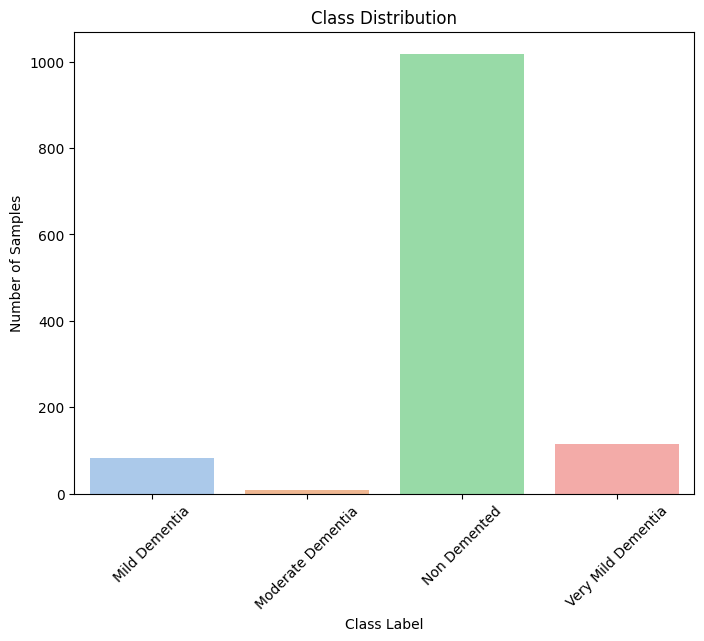

In [ ]:
import seaborn as sns

# Example data (replace with your data)
class_labels = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia']
sample_counts = [82, 8, 1018, 115]

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=sample_counts, palette='pastel')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Assuming you have loaded your volumes_array.pkl and labels_array1.pkl
# volumes_array.pkl contains your feature vectors and labels_array1.pkl contains the corresponding labels

# Reshape the feature vectors if necessary
volumes_array = np.load('/content/drive/MyDrive/Alzheimer_s Dataset/volumes_array.pkl',allow_pickle=True)  # Assuming this contains your feature vectors
labels_array = np.load('/content/drive/MyDrive/Alzheimer_s Dataset/labels_array1.pkl',allow_pickle=True)   # Assuming this contains your labels

# Reshape the feature vectors if necessary
volumes_array = volumes_array.reshape(volumes_array.shape[0], -1)

# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
volumes_resampled, labels_resampled = oversampler.fit_resample(volumes_array, labels_array)

# Check the new class distribution
unique, counts = np.unique(labels_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution after oversampling:")
print(class_distribution)


Class Distribution after oversampling:
{'Mild Dementia': 1018, 'Moderate Dementia': 1018, 'Non Demented': 1018, 'Very mild Dementia': 1018}


In [ ]:
labels_resampled.shape

(4072,)

In [ ]:
# Assuming the original shape of each volume was (61, 248, 496)
original_shape = (61, 248, 496)

# Reshape volumes_resampled to its original shape
volumes_resampled_restored = volumes_resampled.reshape((-1,) + original_shape)

In [ ]:
volumes_resampled_restored.shape

(4072, 61, 248, 496)

In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(labels_resampled, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class Mild Dementia: 1018 samples
Class Moderate Dementia: 1018 samples
Class Non Demented: 1018 samples
Class Very mild Dementia: 1018 samples


In [ ]:
import numpy as np
# Specify the target number of samples for each class
target_samples = 300

# Get unique class labels and their counts
unique_classes, class_counts = np.unique(labels_resampled, return_counts=True)

# Create empty arrays to store limited data
limited_volumes = []
limited_labels = []

# Iterate over each class
for class_label, class_count in zip(unique_classes, class_counts):
    # If the class count is less than the target, include all samples
    if class_count <= target_samples:
        indices = np.where(labels_resampled == class_label)[0]
    # If the class count is greater than the target, randomly sample the required number
    else:
        indices = np.random.choice(np.where(labels_resampled == class_label)[0], target_samples, replace=False)
    limited_volumes.extend(volumes_resampled_restored[indices])
    limited_labels.extend(labels_resampled[indices])

# Convert lists to numpy arrays
limited_volumes = np.array(limited_volumes)
limited_labels = np.array(limited_labels)


In [ ]:
limited_labels.shape

(1200,)

In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(limited_labels, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")


Class Mild Dementia: 300 samples
Class Moderate Dementia: 300 samples
Class Non Demented: 300 samples
Class Very mild Dementia: 300 samples


In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/limited_volumes1.npy', limited_volumes)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/limited_labels1.npy', limited_labels)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/limited_volumes1.npy'
limited_volumes = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", limited_volumes.shape)

Loaded array shape: (1200, 61, 248, 496)


In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/limited_labels1.npy'
limited_labels = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", limited_labels.shape)

Loaded array shape: (1200,)


In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(limited_labels, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class Mild Dementia: 300 samples
Class Moderate Dementia: 300 samples
Class Non Demented: 300 samples
Class Very mild Dementia: 300 samples


In [ ]:
#================= # Split orginal volumes and labels into train and test sets==================

In [ ]:
# Split orginal volumes and labels into train and test sets
from sklearn.preprocessing import LabelBinarizer
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(volumes_array, labels_array, test_size=0.2, shuffle=True, random_state=42)
# Convert labels to one-hot encoding
# Convert labels to strings if they are numeric
y_train_o_str = y_train_o.astype(str)
y_test_o_str = y_test_o.astype(str)
label_binarizer = LabelBinarizer()
# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train_o_one_hot = label_binarizer.fit_transform(y_train_o_str)  # Fit to the training labels
y_test_o_one_hot = label_binarizer.transform(y_test_o_str)
#y_train_o_one_hot = label_binarizer.fit_transform(y_train_o)
#y_test_o_one_hot = label_binarizer.transform(y_test_o)

# Display the lengths of train and test sets
print("Length of X_train:", len(X_train_o)) # split  this data again train Val
print("Length of X_test:", len(y_test_o))   # split  this data again
print("Length of y_train:", len(y_train_o_one_hot))
print("Length of y_test:", len(y_test_o_one_hot))

Length of X_train: 978
Length of X_test: 245
Length of y_train: 978
Length of y_test: 245


In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(y_test_o_str, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class Mild Dementia: 19 samples
Class Moderate Dementia: 1 samples
Class Non Demented: 198 samples
Class Very mild Dementia: 27 samples


In [ ]:
'''import numpy as np
#Using this data only for test.
# Expand dimensions to add channel dimension
X_train_o = np.expand_dims(X_train_o, axis=-1)  # Add channel dimension at the end
X_train_o = np.repeat(X_train_o, 3, axis=-1)'''

In [ ]:
X_train_o.shape

(244, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_o.npy', X_train_o)

In [ ]:
'''import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_o.npy'
X_train_o = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_train_o.shape)'''

Loaded array shape: (244, 61, 248, 496, 3)


In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_o_one_hot.npy', y_train_o_one_hot)

In [ ]:
'''import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_o_one_hot.npy'
y_train_o_one_hot = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_train_o_one_hot.shape)'''

Loaded array shape: (244, 4)


In [ ]:
#========================= End Test =================================

In [ ]:
# Split after oversampleling volumes and labels into train and test sets
from sklearn.preprocessing import LabelBinarizer
X_train, X_test, y_train, y_test = train_test_split(limited_volumes, limited_labels, test_size=0.2, shuffle=True, random_state=42)
# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)

# Display the lengths of train and test sets
print("Length of X_train:", len(X_train)) # split  this data again train Val
print("Length of X_test:", len(X_test))   # split  this data again
print("Length of y_train:", len(y_train_one_hot))
print("Length of y_test:", len(y_test_one_hot))


Length of X_train: 960
Length of X_test: 240
Length of y_train: 960
Length of y_test: 240


In [ ]:
import numpy as np

# Calculate class distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Display class distribution
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class Mild Dementia: 238 samples
Class Moderate Dementia: 240 samples
Class Non Demented: 240 samples
Class Very mild Dementia: 242 samples


In [ ]:
'''import numpy as np
#Using this data only for test.
# Expand dimensions to add channel dimension
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension at the end
X_train = np.repeat(X_train, 3, axis=-1)'''

In [ ]:
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/y_train55_3D.npy', y_train_one_hot)

In [ ]:
'''import numpy as np

# Count the occurrences of each class label in the training data
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Distribution in Training Data:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")'''


Class Distribution in Training Data:
Class Mild Dementia: 63 samples
Class Moderate Dementia: 7 samples
Class Non Demented: 820 samples
Class Very mild Dementia: 88 samples


In [ ]:
y_train.shape

(550,)

In [ ]:
X_train_D, X_val_D, y_train_D, y_val_D = train_test_split(X_train, y_train_one_hot, test_size=0.5, random_state=42)

In [ ]:
X_train_D.shape

(480, 61, 248, 496)

In [ ]:
import numpy as np
#Using this data only for test. (traget set 300)
# Expand dimensions to add channel dimension
X_train_D = np.expand_dims(X_train_D, axis=-1)  # Add channel dimension at the end
X_train_D = np.repeat(X_train_D, 3, axis=-1)

In [ ]:
X_train_D.shape

(480, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D300.npy', X_train_D)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D300.npy'
X_train_D = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_train_D.shape)

Loaded array shape: (480, 61, 248, 496, 3)


In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D300.npy', y_train_D)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D300.npy'
y_train_D = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_train_D.shape)

Loaded array shape: (480, 4)


In [ ]:
import numpy as np
#Using this data only for test.
# Expand dimensions to add channel dimension
X_val_D = np.expand_dims(X_val_D, axis=-1)  # Add channel dimension at the end
X_val_D = np.repeat(X_val_D, 3, axis=-1)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D300.npy', X_val_D)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D300.npy'
X_val_D = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_val_D.shape)

Loaded array shape: (480, 61, 248, 496, 3)


In [ ]:
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D300.npy', y_val_D)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D300.npy'
y_val_D = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_val_D.shape)

Loaded array shape: (480, 4)


In [ ]:
X_val_D.shape

(240, 61, 248, 496, 3)

In [ ]:
#============ Part -1 ===============

In [ ]:
X_train_D1, X_train_D2, y_train_D1, y_train_D2 = train_test_split(X_train_D, y_train_D, test_size=0.5, random_state=42)

In [ ]:
X_train_D1.shape

(240, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D1300.npy', X_train_D1)

In [ ]:
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D1300.npy', y_train_D1)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D1300.npy'
X_train_D1 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_train_D1.shape)

Loaded array shape: (240, 61, 248, 496, 3)


In [5]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D1300.npy'
y_train_D1 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_train_D1.shape)

Loaded array shape: (240, 4)


In [ ]:
#============ Seconde Part ===============

In [ ]:
X_train_D2.shape

(120, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D2300.npy', X_train_D2)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D2300.npy', y_train_D2)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_train_D2300.npy'
X_train_D2 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_train_D2.shape)

In [6]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_train_D2300.npy'
y_train_D2 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_train_D2.shape)

Loaded array shape: (240, 4)


In [ ]:
#================== End Part-1 =============

In [ ]:
#================== Part-2 =====================

In [ ]:
X_val_D1,X_val_D2,y_val_D1,y_val_D2 = train_test_split(X_val_D, y_val_D, test_size=0.5, random_state=42)

In [ ]:
X_val_D1.shape

(240, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D1300.npy', X_val_D1)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D1300.npy', y_val_D1)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D1300.npy'
X_val_D1 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_val_D1.shape)

In [7]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D1300.npy'
y_val_D1 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_val_D1.shape)

Loaded array shape: (240, 4)


In [ ]:
#========= End Part -2 ============

In [ ]:
X_val_D2.shape

(240, 61, 248, 496, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D2300.npy', X_val_D2)

In [8]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_val_D2300.npy'
X_val_D2 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_val_D2.shape)

Loaded array shape: (240, 61, 248, 496, 3)


In [ ]:
y_val_D2.shape

(120, 4)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D2300.npy', y_val_D2)

In [8]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_val_D2300.npy'
y_val_D2 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_val_D2.shape)

Loaded array shape: (240, 4)


In [ ]:
y_val_D2.shape

(120, 4)

In [ ]:
#========= Test Part ===============

In [ ]:
import numpy as np
#Using this data only for test.
# Expand dimensions to add channel dimension
X_test = np.expand_dims(X_test, axis=-1)  # Add channel dimension at the end
X_test = np.repeat(X_test, 3, axis=-1)

In [ ]:
# Save the numpy array(oversample 300 tragerset testset link)
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_test300.npy', y_test_one_hot)

In [ ]:
import numpy as np

# Load the NumPy array file(oversample 300 tragerset testset link)
#file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_test.npy'
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_test300.npy'
X_test300 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_test300.shape)

Loaded array shape: (240, 61, 248, 496, 3)


In [ ]:
# Save the numpy array(oversample 300 tragerset testset link)
np.save('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_testt300.npy', y_test_one_hot)

In [9]:
import numpy as np

# Load the NumPy array file(oversample 300 tragerset testset link)
#file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_test.npy'
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_testt300.npy'
y_test300 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_test300.shape)

Loaded array shape: (240, 4)


In [ ]:
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/X_test_3D1.npy', X_test)

In [11]:
import numpy as np

# Load the NumPy array file
#file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/X_test.npy'
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/X_test_3D1.npy'
X_test_o = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_test_o.shape)

Loaded array shape: (245, 61, 248, 496, 3)


In [13]:
X_test_o.shape

(245, 61, 248, 496, 3)

In [ ]:
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/y_test2_3D.npy', y_test_o_one_hot)

In [10]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/y_test.npy'
y_test = np.load(file_path)
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/y_test2_3D.npy'
y_test1 = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_test.shape)

Loaded array shape: (120, 4)


In [ ]:
y_test1.shape

(245, 4)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.model_selection import train_test_split
input_shape = (61, 248, 496, 3)

# Create the model
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4)  # Assuming 4 output classes, use softmax for multi-class classification
])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 59, 246, 494, 32   2624      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 29, 123, 247, 32   0         
 D)                          )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 27, 121, 245, 64   55360     
                             )                                   
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 13, 60, 122, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 11, 58, 120, 128   2

In [13]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Train the model without validation data
history = model.fit(X_test, y_test, batch_size=8, epochs=10, validation_split=0.0)

Epoch 1/10
 3/31 [=>............................] - ETA: 1:38:46 - loss: 18357.2461 - accuracy: 0.5833

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

In [ ]:
X_train_D1 = model.predict(X_train_D1)

8/8 [==============================] - 583s 71s/step


In [ ]:
import pickle

# Assuming feature_extractor_test is your data
# Save feature_extractor_test to a file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_train_D1_c300.pkl', 'wb') as f:
    pickle.dump(X_train_D1, f)

In [ ]:
feature_extractor_X_train_D2=model.predict(X_train_D2)

8/8 [==============================] - 560s 69s/step


In [ ]:
import pickle

# Assuming feature_extractor_test is your data
# Save feature_extractor_test to a file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_train_D2_c300.pkl', 'wb') as f:
    pickle.dump(feature_extractor_X_train_D2, f)

In [ ]:
feature_extractor_X_val_D1=model.predict(X_val_D1)

8/8 [==============================] - 586s 72s/step


In [ ]:
import pickle

# Assuming feature_extractor_test is your data
# Save feature_extractor_test to a file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_val_D1300.pkl', 'wb') as f:
    pickle.dump(feature_extractor_X_val_D1, f)

In [ ]:
feature_extractor_X_val_D2=model.predict(X_val_D2)

8/8 [==============================] - 561s 69s/step


In [ ]:
import pickle

# Assuming feature_extractor_test is your data
# Save feature_extractor_test to a file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_val_D2300.pkl', 'wb') as f:
    pickle.dump(feature_extractor_X_val_D2, f)

In [14]:
#orginal test dataset
feature_extractor_X_test1 =model.predict(X_test_o)

8/8 [==============================] - 578s 71s/step


In [6]:
feature_extractor_X_test1.shape

(245, 4)

In [ ]:
feature_extractor_X_test2 =model.predict(X_test300)

8/8 [==============================] - 567s 69s/step


In [ ]:
import pickle

# Assuming feature_extractor_test is your data
# Save feature_extractor_test to a file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_test300.pkl', 'wb') as f:
    pickle.dump(feature_extractor_X_test2, f)

In [15]:
import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_train_D1_c300.pkl', 'rb') as f:
    feature_extractor_X_train_D1 = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_train_D1)

[[ 2.59118986e+00  2.87862587e+00  6.18108940e+00 -1.79302425e+01]
 [-5.51800156e+00 -1.57240391e-01 -2.10952187e+00 -4.55539751e+00]
 [-6.88498831e+00  4.75449753e+00 -9.36816406e+00 -9.33726120e+00]
 [ 1.75681210e+00  2.55172825e+00  3.32892585e+00 -2.17527580e+01]
 [-5.88202095e+00  8.01817894e+00 -2.52898788e+00 -5.73729849e+00]
 [ 2.25244713e+00  6.27560139e+00  1.29083061e+00  6.29992008e-01]
 [-6.13568735e+00  5.42895794e-01  2.27903533e+00 -1.02687302e+01]
 [-4.04079628e+00  2.55433202e+00  1.09018481e+00 -2.62521601e+00]
 [-2.30800986e+00  3.05265880e+00 -5.04296398e+00 -1.21653452e+01]
 [-9.57526112e+00  1.30164623e-01  1.36100316e+00 -1.38337851e+01]
 [-6.40030384e-01  3.70165467e+00 -5.09888649e-01 -9.29440594e+00]
 [-3.94970322e+00  5.65810823e+00 -1.11076164e+00 -1.71578999e+01]
 [ 3.08372736e+00  4.32642794e+00  2.42797709e+00 -1.64349899e+01]
 [-6.14799833e+00  8.84249973e+00 -4.57119560e+00 -7.97322607e+00]
 [-2.62833595e-01  7.38436103e-01  2.31836796e-01 -9.03989601e

In [16]:
import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_train_D1 = np.array(feature_extractor_X_train_D1)

# Print the shape of the converted array to verify
print(feature_extractor_X_train_D1.shape)

(240, 4)


In [17]:
import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_train_D2_c300.pkl', 'rb') as f:
    feature_extractor_X_train_D2 = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_train_D2)

[[  1.8736892   -3.332561    -2.3850384    7.4574213 ]
 [ -3.9849942  -10.759614     2.7303352  -10.216979  ]
 [ -3.9849942  -10.759614     2.7303352  -10.216979  ]
 [-11.10719     -6.0700903   -5.458433    -5.6671    ]
 [ -5.527987   -10.789553     8.400368   -13.757437  ]
 [ -4.37963     -6.111986     2.6116762   -1.7780046 ]
 [ -2.6359534   -1.9496915   -8.538233     1.4881725 ]
 [-10.061971   -11.067272     0.6205492   -9.542989  ]
 [ -1.5252666   -8.035224    10.897924    -9.000426  ]
 [ -4.657114    -6.308665     4.3298264   -9.784201  ]
 [  0.5928416   -9.783964     5.9033904   -1.6777296 ]
 [-10.191121    -1.4044257   10.079001    -6.9728713 ]
 [ -5.782819    -8.82291      9.361204    -0.7969365 ]
 [  2.6380088   -6.59579     -2.5132818   -0.32020092]
 [  2.67584    -10.985232     3.988471    -5.2955246 ]
 [ -0.13962007  -2.1904073    7.8206506   -5.6624303 ]
 [ -2.6359534   -1.9496915   -8.538233     1.4881725 ]
 [-10.330627    -6.30238      7.7772403   -0.8191328 ]
 [ -5.0917

In [18]:
import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_train_D2 = np.array(feature_extractor_X_train_D2)

# Print the shape of the converted array to verify
print(feature_extractor_X_train_D2.shape)

(240, 4)


In [19]:
import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_val_D1300.pkl', 'rb') as f:
    feature_extractor_X_val_D1 = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_val_D1)

[[ -5.712588   -16.73993      4.255355   -12.678071  ]
 [ -1.3510057  -15.259115     5.9870014  -17.254045  ]
 [ -3.7703278  -14.797597     8.748238   -17.897644  ]
 [  2.2610476  -13.067088     8.737944    -9.928754  ]
 [-11.111745   -11.867258    10.25052    -15.08718   ]
 [ -7.3699217  -16.075062    15.0782     -13.82889   ]
 [ -1.3183696  -23.417406    11.308408   -13.916191  ]
 [ -3.8142507  -13.330046    16.330246    -7.7623854 ]
 [ -0.55560493 -20.373827    11.679061   -14.3050995 ]
 [  6.672861   -22.143023     9.15797    -11.459679  ]
 [ -0.8549609  -14.443186    18.298721    -6.424914  ]
 [ -6.0070524  -17.292717     3.5537627  -13.218149  ]
 [ -3.8142507  -13.330046    16.330246    -7.7623854 ]
 [  1.4084215   -9.185891    17.815376   -15.538002  ]
 [-14.399282    -8.252249     8.501445   -28.054117  ]
 [ -6.697898   -17.685041     7.4672065  -11.810791  ]
 [  1.7242017  -15.589159    16.810026    -6.2390337 ]
 [ -0.8549609  -14.443186    18.298721    -6.424914  ]
 [ -8.4902

In [20]:
import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_val_D1 = np.array(feature_extractor_X_val_D1)

# Print the shape of the converted array to verify
print(feature_extractor_X_val_D1.shape)

(240, 4)


In [21]:
import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_val_D2300.pkl', 'rb') as f:
    feature_extractor_X_val_D2 = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_val_D2)

[[ 1.00033264e+01  2.62438240e+01 -8.21425915e+00  1.51886044e+01]
 [ 1.65255642e+00  3.27253571e+01 -7.86940575e+00  1.59634113e+01]
 [-1.97345352e+00  3.64411011e+01 -8.72348118e+00  2.23495522e+01]
 [ 5.21612644e+00  3.76881447e+01  2.50679016e-01  1.67309170e+01]
 [ 8.17180824e+00  2.94299965e+01 -9.11161995e+00  1.70914307e+01]
 [ 1.33915520e+01  3.20222168e+01 -8.24928284e-03  2.20522766e+01]
 [ 9.53512192e+00  1.89111004e+01  4.59740448e+00  7.92978954e+00]
 [-3.27118874e+00  3.04601517e+01  7.30749130e-01  1.02693434e+01]
 [-1.97345352e+00  3.64411011e+01 -8.72348118e+00  2.23495522e+01]
 [ 1.82833672e+00  4.53849716e+01 -1.39779263e+01  2.69988937e+01]
 [ 1.82833672e+00  4.53849716e+01 -1.39779263e+01  2.69988937e+01]
 [-1.81549835e+00  4.40884781e+01 -1.00432529e+01  2.68291893e+01]
 [-2.11070442e+00  3.26956902e+01 -9.97575855e+00  2.35159302e+01]
 [-4.17111778e+00  2.56214943e+01 -2.92761421e+00  1.10979099e+01]
 [-3.27118874e+00  3.04601517e+01  7.30749130e-01  1.02693434e

In [22]:
import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_val_D2 = np.array(feature_extractor_X_val_D2)

# Print the shape of the converted array to verify
print(feature_extractor_X_val_D2.shape)

(240, 4)


In [23]:
import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_test300.pkl', 'rb') as f:
    feature_extractor_X_test = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_test)

[[ 3.10123467e+00  8.43084908e+00 -4.54695415e+00 -7.49645233e-02]
 [ 1.38730783e+01  1.73276157e+01 -1.62245846e+00  4.54535198e+00]
 [-4.98419666e+00  1.63020706e+01 -3.15011406e+00 -1.83731556e+00]
 [-7.85838962e-01  1.16136036e+01 -2.46739292e+00  9.45266819e+00]
 [ 2.46170254e+01  1.96638317e+01 -2.26166248e+00 -6.82027817e-01]
 [ 5.18562984e+00  8.58766651e+00  1.19162140e+01  3.57317066e+00]
 [ 5.11019945e+00  1.20938807e+01  8.39037132e+00 -1.50197029e-01]
 [ 6.59936619e+00  6.96744442e+00 -5.53258419e+00  7.34888268e+00]
 [ 1.00964594e+00  9.52665234e+00 -1.34518433e+00  1.28166676e+01]
 [ 8.96962643e+00  9.08220577e+00  4.32590485e+00  1.17078314e+01]
 [-8.47019672e+00 -2.77594042e+00 -3.26998711e+00  5.81758928e+00]
 [ 1.96538525e+01  1.42273617e+01 -2.72549152e+00  1.05405579e+01]
 [ 1.41497297e+01  1.40738602e+01  5.17605972e+00  2.16995716e+00]
 [ 1.38873997e+01  1.81828232e+01  3.89847374e+00  2.71503401e+00]
 [ 1.67080860e+01  2.12822742e+01  8.21630478e-01  6.72161865e

In [24]:
import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_test = np.array(feature_extractor_X_test)

# Print the shape of the converted array to verify
print(feature_extractor_X_test.shape)

(240, 4)


In [ ]:
'''import pickle

# Load the feature_extractor_test data from the file
with open('/content/drive/MyDrive/Without_Softmax_Feature_3DCNN/feature_extractor_X_test1.pkl', 'rb') as f:
    feature_extractor_X_test1 = pickle.load(f)

# Now you can use feature_extractor_test as your loaded data
print(feature_extractor_X_test1)'''

[[ 12.124198     0.9492941   -2.2559915   24.938059  ]
 [ 12.109632    -1.540514   -22.358864    23.367935  ]
 [ 23.616201    11.600473   -17.097466    12.531915  ]
 [ 10.716148    12.503692   -12.197863    22.66821   ]
 [  2.5144005   13.317081    -9.558115    27.974398  ]
 [ 16.825663     2.363532    -9.826578    29.632244  ]
 [ 17.888348    -4.7848473  -22.01096      3.9157777 ]
 [ 18.093048     4.6378117  -12.396762     8.360537  ]
 [  9.258086     1.6725044   -9.296719    17.226974  ]
 [ 22.672005     9.710102   -17.91446     22.930424  ]
 [ 14.137874    15.544523    -2.1452608   14.351877  ]
 [ 25.346912     5.254443    -6.4593925   23.753515  ]
 [ 11.327723     4.884877   -11.800726    27.561043  ]
 [  7.269219     0.13608646 -10.215126    21.331383  ]
 [ 12.586076    12.85866    -15.128756    26.318012  ]
 [ 11.833367    12.7464485  -18.44465     28.138252  ]
 [ 24.09458     15.150471   -11.575217     9.102444  ]
 [ 26.155636     0.9419689   -7.339866    17.111755  ]
 [ 14.8654

In [ ]:
'''import numpy as np

# Convert list of lists to NumPy array
feature_extractor_X_test1 = np.array(feature_extractor_X_test1)

# Print the shape of the converted array to verify
print(feature_extractor_X_test1.shape)'''

(244, 4)


In [25]:
import numpy as np

# Assuming feature_extractor_Train and feature_extractor_Test are numpy arrays
# Concatenate feature_extractor_Train and feature_extractor_Test along the first axis (rows)
merged_features = np.concatenate((feature_extractor_X_train_D1,feature_extractor_X_train_D2,feature_extractor_X_val_D1,feature_extractor_X_val_D2,feature_extractor_X_test), axis=0)

print(merged_features.shape)  # Check the shape of the merged features
 # Check the shape of the merged features



(1200, 4)


In [26]:
# Now you can use merged_features as your loaded data
print(merged_features)

[[  2.5911899    2.8786259    6.1810894  -17.930243  ]
 [ -5.5180016   -0.15724039  -2.1095219   -4.5553975 ]
 [ -6.8849883    4.7544975   -9.368164    -9.337261  ]
 ...
 [  1.0096459    9.526652    -1.3451843   12.816668  ]
 [  1.8914032    8.612579    -4.416356    13.272576  ]
 [  3.1160998   10.625656    10.48101     11.052687  ]]


In [ ]:
'''params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'missing': 1,
    'n_estimators': 100,
    'n_jobs': -1,
    'nthread': None,
    'random_state': 1855,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': None,
    'silent': None,
    'subsample': 1,
    'verbosity': 0,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 7,
    # Set number of GPUs if available
    'n_gpus': 0,
    'predictor': 'gpu_predictor'
}

modelXG = XGBClassifier(**params)'''

In [27]:
# Convert true y_train_D1 labels to integers
#y_train_D1_int = label_binarizer.inverse_transform(y_train_D1)
y_train_D1_int = np.argmax(y_train_D1, axis=1)

In [ ]:
y_train_D1_int.shape

(240,)

In [28]:
# Convert true y_train_D1 labels to integers
y_train_D2_int = np.argmax(y_train_D2, axis=1)
#y_train_D2_int = label_binarizer.inverse_transform(y_train_D2)

In [ ]:
y_train_D2_int.shape

(240,)

In [29]:
# Convert true y_train_D1 labels to integers
y_val_D1_int = np.argmax(y_val_D1, axis=1)
#y_val_D1_int = label_binarizer.inverse_transform(y_val_D1)

In [ ]:
y_val_D1_int.shape

(240,)

In [30]:
# Convert true y_train_D1 labels to integers
y_val_D2_int = np.argmax(y_val_D2, axis=1)
#y_val_D2_int = label_binarizer.inverse_transform(y_val_D2)

In [ ]:
y_val_D2_int.shape

(240,)

In [31]:
# Convert true y_train_D1 labels to integers
y_test300 = np.argmax(y_test300, axis=1)
#y_test300 = label_binarizer.inverse_transform(y_test300)

In [ ]:
y_test300.shape

(240,)

In [32]:
import numpy as np

# Assuming y_test_int and y_train_1_int are numpy arrays
# Concatenate y_test_int and y_train_1_int arrays along the first axis (rows)
merged_labels = np.concatenate((y_train_D1_int, y_train_D2_int,y_val_D1_int,y_val_D2_int,y_test300), axis=0)

print(merged_labels.shape)

(1200,)


In [ ]:
#y_train_encoded = label_encoder.fit_transform(merged_labels)

In [ ]:
import numpy as np

# Assuming merged_features is your numpy array
dimensionality = len(merged_features.shape)

print("Dimensionality of merged_features:", dimensionality)



Dimensionality of merged_features: 2


In [ ]:
# Preprocess data (assuming merged_features and merged_labels are your data)
scaler = StandardScaler()
scaled_features1 = scaler.fit_transform(feature_extractor_X_test1)

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform, randint

# Define parameter distributions for randomized search
param_dist = {
    'learning_rate': uniform(0.01, 0.3),      # Continuous distribution between 0.01 and 0.31
    'max_depth': randint(3, 10),               # Discrete uniform distribution between 3 and 10
    'n_estimators': randint(100, 1000),        # Discrete uniform distribution between 100 and 1000
    'min_child_weight': uniform(1, 10),        # Continuous distribution between 1 and 11
    'gamma': uniform(0, 0.5),                  # Continuous distribution between 0 and 0.5
    'subsample': uniform(0.5, 0.5),            # Continuous distribution between 0.5 and 1
    'colsample_bytree': uniform(0.5, 0.5)      # Continuous distribution between 0.5 and 1
}

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform randomized search cross-validation
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=4, n_jobs=-1, verbosity=1),
    param_distributions=param_dist, cv=cv, scoring='accuracy', n_iter=100, verbose=1, random_state=42
)
random_search.fit(merged_features, merged_labels)

# Get best hyperparameters
best_params = random_search.best_params_

# Initialize XGBoost classifier with best hyperparameters
modelXG = XGBClassifier(**best_params, objective='multi:softmax', num_class=4, verbosity=1, n_jobs=-1)

# Train XGBoost model
modelXG.fit(merged_features, merged_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8408068344863948, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.17031228473212,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08820835847077092,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2.1816482762165625, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=-1, num_class=4, num_parallel_tree=None, ...)

In [ ]:
#modelXG.fit(merged_features,merged_labels)

In [ ]:
# Preprocess data (assuming merged_features and merged_labels are your data)
scaler = StandardScaler()
scaled_features1 = scaler.fit_transform(feature_extractor_X_test1)

In [34]:
# Make predictions with your trained XGBoost model
predictions_test = modelXG.predict(feature_extractor_X_test1)

# Evaluate the model's performance on the test data
#print(classification_report(true_labels_test, predictions_test)) y_train_o_one_hot

In [ ]:
XG_test_pred = modelXG.predict(feature_extractor_X_test)

In [33]:
predictions_test.shape

(245,)

In [ ]:
# Convert one-hot encoded labels back to original labels
#y_test_original = label_binarizer.inverse_transform(y_test_o_one_hot)

In [35]:
y_test1 = np.argmax(y_test1, axis=1)

In [38]:
y_test1.shape

(245,)

In [36]:
targetnames = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]
print(classification_report(y_test1, predictions_test, target_names=targetnames,zero_division=1))

                    precision    recall  f1-score   support

     Mild Dementia       0.06      0.05      0.05        19
 Moderate Dementia       0.00      0.00      0.00         1
      Non Demented       0.85      0.56      0.67       198
Very mild Dementia       0.14      0.48      0.21        27

          accuracy                           0.51       245
         macro avg       0.26      0.27      0.23       245
      weighted avg       0.71      0.51      0.57       245



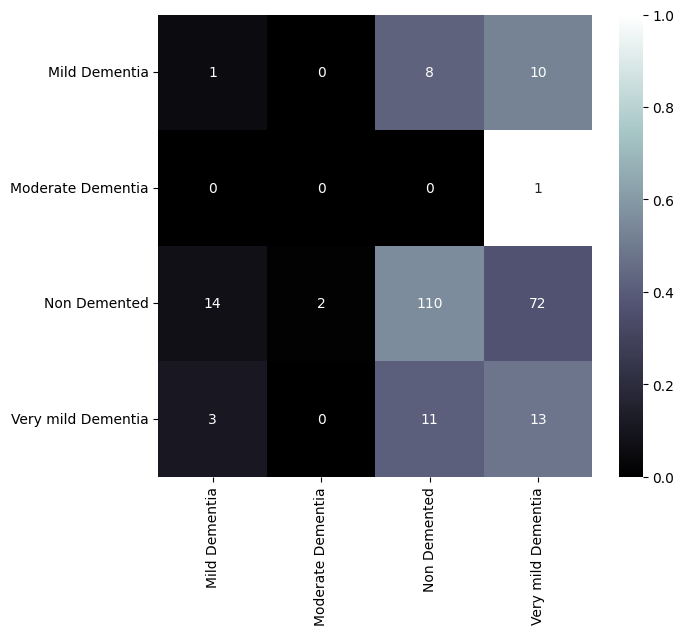

In [37]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

cm = confusion_matrix(y_test1,predictions_test)
plot_confusion_matrix(cm, targetnames)

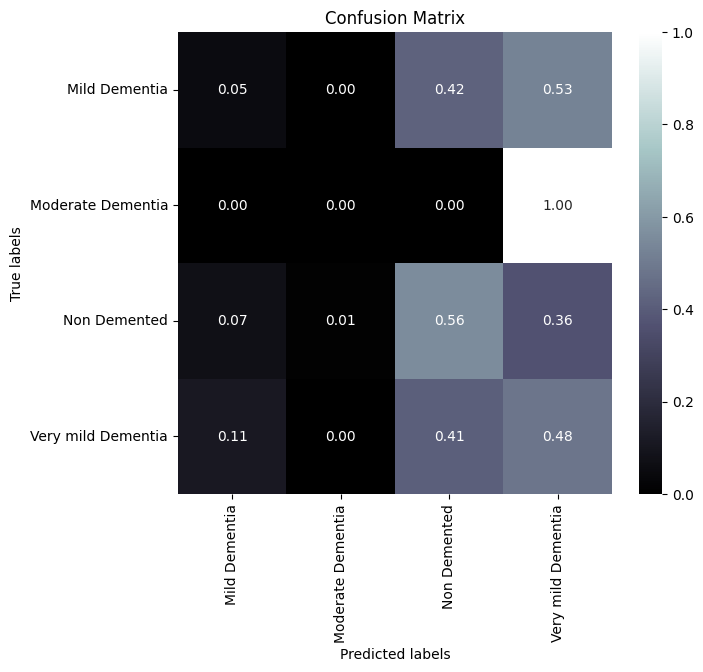

Class Mild Dementia:
Sensitivity (True Positive Rate): 0.05263157894736842
Specificity (True Negative Rate): 0.9247787610619469

Class Moderate Dementia:
Sensitivity (True Positive Rate): 0.0
Specificity (True Negative Rate): 0.9918032786885246

Class Non Demented:
Sensitivity (True Positive Rate): 0.5555555555555556
Specificity (True Negative Rate): 0.5957446808510638

Class Very mild Dementia:
Sensitivity (True Positive Rate): 0.48148148148148145
Specificity (True Negative Rate): 0.6192660550458715

              precision    recall  f1-score   support

           0       0.06      0.05      0.05        19
           1       0.00      0.00      0.00         1
           2       0.85      0.56      0.67       198
           3       0.14      0.48      0.21        27

    accuracy                           0.51       245
   macro avg       0.26      0.27      0.23       245
weighted avg       0.71      0.51      0.57       245



In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(norm_cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap=cmap)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate sensitivity and specificity for each class
    for i in range(len(classes)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        print(f"Class {classes[i]}:")
        print("Sensitivity (True Positive Rate):", sensitivity)
        print("Specificity (True Negative Rate):", specificity)
        print()

# Assuming y_test1 contains the true labels and predictions_test contains the predicted labels
cm = confusion_matrix(y_test1, predictions_test)
plot_confusion_matrix(cm, targetnames)

# Print classification report
print(classification_report(y_test1, predictions_test))